In [1]:
# System
import os
import sys

# Maths
import numpy as np
from scipy.spatial import ConvexHull
from scipy.stats import pearsonr

# Plotting
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.lines import Line2D
from matplotlib.patches import ConnectionPatch
from matplotlib.patches import Rectangle, Patch
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize, DivergingNorm, to_rgba

# Atoms
from ase.io import read, write
from ase.visualize.plot import plot_atoms
import chemiscope

# ML
from sklearn.metrics import pairwise_distances, confusion_matrix

# Utilities
import h5py
import json
import project_utils as utils
import gzip
from copy import deepcopy
from tools import load_json, recursive_array_convert

# Import COSMO style toolkit
import cosmoplot.colorbars as cosmocbars
import cosmoplot.style as cosmostyle

cosmostyle.set_style('article')
color_list = cosmostyle.color_cycle

# Load Data

In [2]:
cutoff = 6.0
spectrum = 'power'
spectrum_name = spectrum.capitalize()
group_name = 'OO+OSi+SiSi'
mixing_suffixes = ['', '_0.0', '_1.0']
mixing = ''
df_types = ['OvR', 'OvO']
df_type = 'OvR'

In [3]:
ticklabels = {
    2: ['IZA', 'DEEM'],
    4: ['IZA1', 'IZA2', 'IZA3', 'DEEM']
}

In [4]:
model_dir = '../../Processed_Data/Models'

deem_name = 'DEEM_330k'
iza_name = 'IZA_230'
deem_dir = f'../../Processed_Data/{deem_name}/Data'
iza_dir = f'../../Processed_Data/{iza_name}/Data'
ch_dir = f'{model_dir}/{cutoff}/CH/{df_type}/4-Class/{spectrum_name}/{group_name}'

## Test and train sets

In [5]:
# Load train and test indices
deem_train_idxs = np.loadtxt('../../Processed_Data/DEEM_330k/svm_train.idxs', dtype=int)
deem_test_idxs = np.loadtxt('../../Processed_Data/DEEM_330k/svm_test.idxs', dtype=int)
deem_idxs = np.concatenate((deem_train_idxs, deem_test_idxs))

iza_train_idxs = np.loadtxt('../../Processed_Data/IZA_230/svm_train.idxs', dtype=int)
iza_test_idxs = np.loadtxt('../../Processed_Data/IZA_230/svm_test.idxs', dtype=int)
iza_idxs = np.concatenate((iza_train_idxs, iza_test_idxs))
iza_sort_idxs = np.argsort(iza_idxs)
iza_unsort_idxs = np.argsort(iza_sort_idxs)

In [6]:
# Load cantons for IZA and Deem
iza_cantons = np.loadtxt('../../Raw_Data/IZA_230/cantons_compositions.dat', usecols=1, dtype=int)[iza_idxs]
iza_codes = np.loadtxt('../../Raw_Data/IZA_230/cantons_compositions.dat', usecols=0, dtype=str)[iza_idxs]
n_iza = len(iza_codes)

deem_cantons_2 = np.loadtxt('../../Processed_Data/DEEM_330k/Data/cantons_2-class.dat', dtype=int)[deem_idxs]
deem_cantons_4 = np.loadtxt('../../Processed_Data/DEEM_330k/Data/cantons_4-class.dat', dtype=int)[deem_idxs]
deem_codes = np.arange(0, 331172) + 8000001
deem_codes = deem_codes[deem_idxs]
n_deem = len(deem_codes)

codes = np.concatenate((iza_codes, deem_codes))
cantons_2 = np.concatenate((np.ones(n_iza, dtype=int), deem_cantons_2))
cantons_4 = np.concatenate((iza_cantons, deem_cantons_4))

## Properties, projections, and structures

In [7]:
# Atomic structures
frames = read(f'{ch_dir}/iza+deem.xyz', index=':')

In [8]:
# Projections
T = np.loadtxt(f'{ch_dir}/T{mixing}.dat')

In [9]:
# Si fractions
Si_fraction_iza = np.loadtxt('../../Raw_Data/IZA_230/cantons_compositions.dat', usecols=2)[iza_idxs]
Si_fraction_deem = np.ones(n_deem) / 3
Si_fraction = np.concatenate((Si_fraction_iza, Si_fraction_deem))

predicted_Si_fraction_iza = np.loadtxt(
    f'../../Processed_Data/IZA_230/Data/{cutoff}/LRR/Composition/lr_structure_properties.dat'
)[iza_idxs]
predicted_Si_fraction_deem = np.loadtxt(
    f'../../Processed_Data/DEEM_330k/Data/{cutoff}/LRR/Composition/lr_structure_properties.dat'
)[deem_idxs]
predicted_Si_fraction = np.concatenate((predicted_Si_fraction_iza, predicted_Si_fraction_deem))

In [10]:
# Structure energies
deem_330k_energies = np.loadtxt('../../Processed_Data/DEEM_330k/Data/structure_energies.dat')[deem_idxs]
iza_energies = np.loadtxt('../../Processed_Data/IZA_230/Data/structure_energies.dat')[iza_idxs]
energies = np.concatenate((iza_energies, deem_330k_energies))

# Energies used in the hull construction
ch_energies = np.loadtxt(f'{ch_dir}/energies_per_si.dat')

In [11]:
# Structure volumes
deem_330k_volumes = np.loadtxt('../../Processed_Data/DEEM_330k/Data/structure_volumes.dat')[deem_idxs]
iza_volumes = np.loadtxt('../../Processed_Data/IZA_230/Data/structure_volumes.dat')[iza_idxs]
volumes = np.concatenate((iza_volumes, deem_330k_volumes))

In [12]:
# Decision functions
deem_330k_dfs_2 = np.loadtxt(
    f'{deem_dir}/{cutoff}/LSVC/{df_type}/2-Class/{spectrum_name}/{group_name}/svc_structure_dfs.dat'
)[deem_idxs]
deem_330k_dfs_4 = np.loadtxt(
    f'{deem_dir}/{cutoff}/LSVC/{df_type}/4-Class/{spectrum_name}/{group_name}/svc_structure_dfs.dat'
)[deem_idxs]

iza_dfs_2 = np.loadtxt(
    f'{iza_dir}/{cutoff}/LSVC/{df_type}/2-Class/{spectrum_name}/{group_name}/svc_structure_dfs.dat'
)[iza_idxs]
iza_dfs_4 = np.loadtxt(
    f'{iza_dir}/{cutoff}/LSVC/{df_type}/4-Class/{spectrum_name}/{group_name}/svc_structure_dfs.dat'
)[iza_idxs]

dfs_2 = np.concatenate((iza_dfs_2, deem_330k_dfs_2))
dfs_4 = np.concatenate((iza_dfs_4, deem_330k_dfs_4))

In [13]:
dfs = dfs_2

In [14]:
# 4-Class cantons
predicted_deem_cantons_2 = np.loadtxt(
    f'{deem_dir}/{cutoff}/LSVC/{df_type}/2-Class/{spectrum_name}/{group_name}/svc_structure_cantons.dat', dtype=int
)[deem_idxs]
predicted_deem_cantons_4 = np.loadtxt(
    f'{deem_dir}/{cutoff}/LSVC/{df_type}/4-Class/{spectrum_name}/{group_name}/svc_structure_cantons.dat', dtype=int
)[deem_idxs]

predicted_iza_cantons_2 = np.loadtxt(
    f'{iza_dir}/{cutoff}/LSVC/{df_type}/2-Class/{spectrum_name}/{group_name}/svc_structure_cantons.dat', dtype=int
)[iza_idxs]
predicted_iza_cantons_4 = np.loadtxt(
    f'{iza_dir}/{cutoff}/LSVC/{df_type}/4-Class/{spectrum_name}/{group_name}/svc_structure_cantons.dat', dtype=int
)[iza_idxs]

predicted_cantons_2 = np.concatenate((predicted_iza_cantons_2, predicted_deem_cantons_2))
predicted_cantons_4 = np.concatenate((predicted_iza_cantons_4, predicted_deem_cantons_4))

In [15]:
np.all(np.argmax(deem_330k_dfs_4, axis=1)+1 == predicted_deem_cantons_4)

True

# Convex hull analysis

In [16]:
ndim = 3

In [17]:
ch_vertices = np.loadtxt(f'{ch_dir}/hull_vertices{mixing}.dat', dtype=int)
iza_vertices = ch_vertices[ch_vertices < n_iza]
deem_vertices = ch_vertices[ch_vertices >= n_iza]

vertex_indicators = np.zeros(T.shape[0], dtype=int)
vertex_indicators[ch_vertices] = 1

d = np.loadtxt(f'{ch_dir}/hull_distances{mixing}.dat')
de = np.loadtxt(f'{ch_dir}/hull_distances_energy{mixing}.dat')

In [18]:
de[ch_vertices]

array([-0.00000000e+00, -2.44323572e-12, -2.74168389e-12, -0.00000000e+00,
       -2.31063833e-12, -0.00000000e+00, -0.00000000e+00, -2.07307238e-12,
       -2.07316144e-12, -1.70572798e-12, -0.00000000e+00, -2.71215787e-12,
       -0.00000000e+00, -0.00000000e+00, -2.71541656e-12, -2.17406181e-12,
       -1.61402195e-12, -0.00000000e+00, -0.00000000e+00, -5.43083312e-12,
       -2.40630880e-12, -2.02467683e-12, -1.70572798e-12, -1.62512293e-12,
       -0.00000000e+00, -1.61402195e-12, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -2.74168389e-12, -0.00000000e+00, -0.00000000e+00,
       -1.52395388e-12, -2.02556822e-12, -0.00000000e+00, -0.00000000e+00,
       -2.17406181e-12, -0.00000000e+00])

## Plot convex hull

In [19]:
def histogram(X, Y, bins, return_edges=False):
    Z, X_edges, Y_edges = np.histogram2d(X, Y, bins=bins, density=True)
    dX = np.diff(X_edges)
    dY = np.diff(Y_edges)
    X_centers = X_edges[0:-1]
    Y_centers = Y_edges[0:-1]
    X_centers += dX / 2
    Y_centers += dY / 2
    X, Y = np.meshgrid(X_centers, Y_centers)
    
    if return_edges:
        return X, Y, Z.T, X_edges, Y_edges
    else:
        return X, Y, Z.T
    
def logbase(x, base):
    return np.log10(x) / np.log10(base)
    
def scale_points(data, min_value, max_value, inverted=False, log=False, base=10, min_limit=None, max_limit=None):
    data = data.copy()
    if min_limit is not None:
        data[data < min_limit] = min_limit
    if max_limit is not None:
        data[data > max_limit] = max_limit
    
    normalized_data = (data - np.amin(data)) / (np.amax(data) - np.amin(data))
    if inverted:
        normalized_data = 1.0 - normalized_data
    
    if log:
        scaled_data = base ** (
            normalized_data * (
                logbase(max_value, base) - logbase(min_value, base)
            ) + logbase(min_value, base)
        )
    else:
        scaled_data =  normalized_data * (max_value - min_value) + min_value

    return scaled_data

In [20]:
frames_deem_vertices = [frames[idx] for idx in deem_vertices]
frames_iza_vertices = [frames[idx] for idx in iza_vertices]

In [21]:
deem_select = [8158735, 8054476, 8312395] #[8326505, 8054476, 8124791, 8321687, 8328575]
iza_select = [] #['MTN', 'SBN']

deem_select_idxs = [np.nonzero(codes == str(code))[0][0] for code in deem_select]
iza_select_idxs = [np.nonzero(codes == code)[0][0] for code in iza_select]

frames_deem_select = [frames[idx] for idx in deem_select_idxs]
frames_iza_select = [frames[idx] for idx in iza_select_idxs]

n_select = len(deem_select) + len(iza_select)

In [22]:
vertex_structure_dir = f'{ch_dir}/Vertex_Structures'
os.makedirs(vertex_structure_dir, exist_ok=True)

# cell_size = 50
# for frame in frames_deem_vertices:
#     min_cell_length = np.amin(frame.cell.lengths())
#     n_repeats = np.ceil(cell_size / min_cell_length).astype(int).tolist()
#     write(
#         f"{vertex_structure_dir}/{os.path.splitext(frame.info['Filename'])[0]}"
#         f"_{n_repeats}x{n_repeats}x{n_repeats}.pdb",
#         frame.repeat(n_repeats),
#         format='proteindatabank'
#     )
#     write(
#         f"{vertex_structure_dir}/{os.path.splitext(frame.info['Filename'])[0]}.cif",
#         frame,
#         format='cif'
#     )
    
# for frame in frames_iza_vertices:
#     min_cell_length = np.amin(frame.cell.lengths())
#     n_repeats = np.ceil(cell_size / min_cell_length).astype(int).tolist()
#     write(
#         f"{vertex_structure_dir}/{frame.info['code']}"
#         f"_{n_repeats}x{n_repeats}x{n_repeats}.pdb",
#         frame.repeat(n_repeats),
#         format='proteindatabank'
#     )
#     write(
#         f"{vertex_structure_dir}/{os.path.splitext(frame.info['code'])[0]}.cif",
#         frame,
#         format='cif'
#     )

for frame in frames_deem_select:
    write(
        f"{vertex_structure_dir}/{os.path.splitext(frame.info['Filename'])[0]}.cif",
        frame,
        format='cif'
    )
        
for frame in frames_iza_select:
    write(
        f"{vertex_structure_dir}/{os.path.splitext(frame.info['code'])[0]}.cif",
        frame,
        format='cif'
    )

In [23]:
base = 10
size_min = 1
size_max = 50
alpha_min = 0.01
alpha_max = 1.0
tol = None
sizes = scale_points(de, size_min, size_max, inverted=True, log=True, base=base, min_limit=tol)
alphas = scale_points(de, alpha_min, alpha_max, inverted=True, log=True, base=base, min_limit=tol)

df_limits = np.abs([np.amin(dfs), np.amax(dfs)])
df_idx = np.argmin(df_limits)
df_limit = df_limits[df_idx]
if df_idx == 0:
    extend_key = 'max'
else:
    extend_key = 'min'
extend_key = 'neither'

# vmin = -df_limit
vmin = np.amin(dfs)
# vmax = df_limit
vmax = np.amax(dfs)

norm = DivergingNorm(vcenter=0.0, vmin=vmin, vmax=vmax)
color_map = ScalarMappable(norm=norm, cmap='RdBu')
colors = color_map.to_rgba(dfs, alpha=1.0)
colors[:, -1] = alphas

norm_composition = Normalize(vmin=0.0, vmax=0.33)
color_map_composition = ScalarMappable(norm=norm_composition, cmap='inferno')

ecolors = np.tile(to_rgba(color_list[0]), (len(colors), 1))
ecolors[:, -1] = alphas

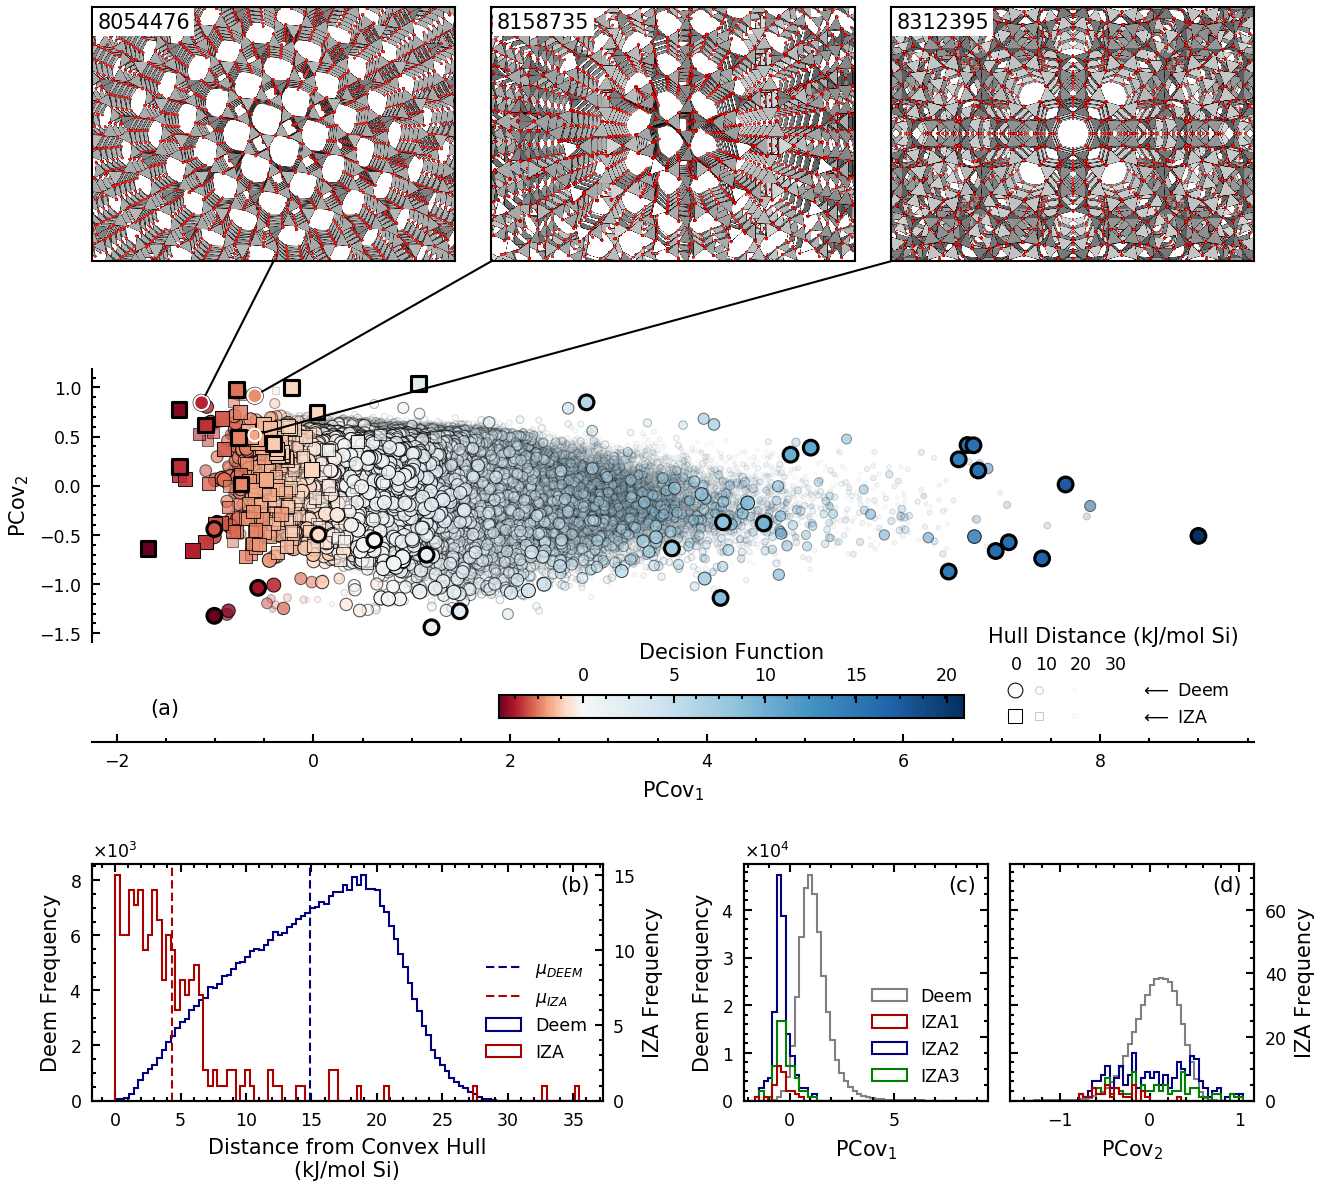

In [24]:
T_ratio = (np.amax(T[:, 0]) - np.amin(T[:, 0])) / (np.amax(T[:, 1]) - np.amin(T[:, 1]))
width_ratios = (1.0, 1.0, 0.4, 1.0, 1.0)
height_ratios = (0.5, 1.0, 0.05, 0.5)
fig_width = 10.0
fig_height = 2 * sum(height_ratios) * (fig_width / T_ratio)

fig = plt.figure(figsize=(fig_width, fig_height))
gs_base = fig.add_gridspec(
    nrows=2, ncols=1,
    height_ratios=(1.0, 2 * np.sum(height_ratios[1:])),
    hspace=0.0
)
gs = gs_base[1].subgridspec(
    nrows=3, ncols=5,
    width_ratios=width_ratios, height_ratios=height_ratios[1:],
    wspace=0.10, hspace=0.20
)
gs_atoms = gs_base[0].subgridspec(
    nrows=1, ncols=n_select,
    wspace=0.10
)

atoms_axes = [fig.add_subplot(gs_atoms[i], zorder=5) for i in range(0, n_select)]
for ax in atoms_axes:
    ax.tick_params(
        which='both', axis='both', 
        left=False, right=False, top=False, bottom=False,
        labelleft=False, labelright=False, labeltop=False, labelbottom=False
    )

# CH
axs = fig.add_subplot(gs[0, :])
axs.set_aspect(aspect='equal', anchor='W', adjustable='datalim')
deem_hull_axs = fig.add_subplot(gs[-1, 0:2])
iza_hull_axs = deem_hull_axs.twinx()
caxs = axs.inset_axes([0.35, 0.05, 0.4, 0.05])
deem_pcovr_axes = [fig.add_subplot(gs[-1, i]) for i in range(-2, 0)]
iza_pcovr_axes = [ax.twinx() for ax in deem_pcovr_axes]
deem_grouper = deem_pcovr_axes[0].get_shared_y_axes()
for ax in deem_pcovr_axes:
    deem_grouper.join(ax, deem_pcovr_axes[0])
    
iza_grouper = iza_pcovr_axes[0].get_shared_y_axes()
for ax in iza_pcovr_axes:
    iza_grouper.join(ax, iza_pcovr_axes[0])
    
iza_pcovr_axes[0].tick_params(labelright=False)
deem_pcovr_axes[1].tick_params(labelleft=False)

T_iza = np.delete(T[0:n_iza], iza_vertices, axis=0)
de_iza = np.delete(de[0:n_iza], iza_vertices)
df_iza = np.delete(dfs[0:n_iza], iza_vertices)
s_iza = np.delete(sizes[0:n_iza], iza_vertices)
colors_iza = np.delete(colors[0:n_iza], iza_vertices, axis=0)
ecolors_iza = np.delete(ecolors[0:n_iza], iza_vertices, axis=0)
po_iza = np.flip(np.argsort(de_iza))

T_deem = np.delete(T[n_iza:], deem_vertices - n_iza, axis=0)
de_deem = np.delete(de[n_iza:], deem_vertices - n_iza)
df_deem = np.delete(dfs[n_iza:], deem_vertices - n_iza)
s_deem = np.delete(sizes[n_iza:], deem_vertices - n_iza)
colors_deem = np.delete(colors[n_iza:], deem_vertices - n_iza, axis=0)
ecolors_deem = np.delete(ecolors[n_iza:], deem_vertices - n_iza, axis=0)
po_deem = np.flip(np.argsort(de_deem))

T_iza_vertices = T[iza_vertices]
de_iza_vertices = de[iza_vertices]
df_iza_vertices = dfs[iza_vertices]
s_iza_vertices = sizes[iza_vertices]
colors_iza_vertices = colors[iza_vertices]
ecolors_iza_vertices = ecolors[iza_vertices]

T_deem_vertices = T[deem_vertices]
de_deem_vertices = de[deem_vertices]
df_deem_vertices = dfs[deem_vertices]
s_deem_vertices = sizes[deem_vertices]
colors_deem_vertices = colors[deem_vertices]
ecolors_deem_vertices = ecolors[deem_vertices]

# Deem
deem_pts = axs.scatter(
    T_deem[po_deem, 0], T_deem[po_deem, 1],
    c=colors_deem[po_deem],
    marker='o', edgecolor=ecolors_deem[po_deem], linewidth=0.5, s=s_deem[po_deem],
    rasterized=True
)
# IZA
iza_pts = axs.scatter(
    T_iza[po_iza, 0], T_iza[po_iza, 1],
    c=colors_iza[po_iza],
    marker='s', edgecolor=ecolors_iza[po_iza], linewidth=0.5, s=s_iza[po_iza],
    rasterized=True
)

# Deem vertices
axs.scatter(
    T_deem_vertices[:, 0], T_deem_vertices[:, 1],
    c=colors_deem_vertices,
    marker='o', edgecolor=ecolors_deem_vertices, linewidth=1.5, s=s_deem_vertices,
    zorder=3,
    rasterized=True
)

# IZA vertices
axs.scatter(
    T_iza_vertices[:, 0], T_iza_vertices[:, 1],
    c=colors_iza_vertices,
    marker='s', edgecolor=ecolors_iza_vertices, linewidth=1.5, s=s_iza_vertices,
    zorder=3,
    linewidths=2,
    rasterized=True
)

# Deem select
axs.scatter(
    T[deem_select_idxs, 0], T[deem_select_idxs, 1],
    c=colors[deem_select_idxs],
    marker='o', edgecolor='w', linewidth=1, s=sizes[deem_select_idxs],
    zorder=3,
    rasterized=True
)

# IZA select
axs.scatter(
    T[iza_select_idxs, 0], T[iza_select_idxs, 1],
    c=colors[iza_select_idxs],
    marker='s', edgecolor='w', linewidth=1, s=sizes[iza_select_idxs],
    zorder=3,
    rasterized=True
)

cb = fig.colorbar(
    color_map, cax=caxs, 
    label='Decision Function', 
    orientation='horizontal', 
    extend=extend_key,
    ticklocation='top'
)

axs.set_xlabel(r'PCov$_1$')
axs.set_ylabel(r'PCov$_2$')

xcenter = 0.0
xlim = axs.get_xlim()
xticks = axs.get_xticks()
xticks_minor = axs.get_xticks(minor=True)
xticklabels = axs.get_xticklabels()

ycenter = 0.0
ylim = axs.get_ylim()
yticks = axs.get_yticks()
yticks_minor = axs.get_yticks(minor=True)
yticklabels = axs.get_yticklabels()

axs.set_xticks(xticks[1:-1]) # We seem to have extra major ticks at the limits
axs.set_xticks(xticks_minor, minor=True)

axs.set_yticks(yticks[1:-1]) # We seem to have extra major ticks at the limits
axs.set_yticks(yticks_minor, minor=True)

axs.spines['left'].set_bounds(*ylim)
axs.spines['bottom'].set_bounds(*xlim)

axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.tick_params(which='both', axis='both', top=False, right=False)

legend_distances = np.linspace(int(np.amin(de)), 10*int(np.amax(de) // 10), 4, dtype=int)
legend_sizes = scale_points(legend_distances, size_min, size_max, inverted=True, log=True, base=base, min_limit=0.0)
legend_alphas = scale_points(legend_distances, alpha_min, alpha_max, inverted=True, log=True, base=base, min_limit=0.0)

legend_patches = []
for legend_distance, legend_size, legend_alpha in zip(legend_distances, legend_sizes, legend_alphas):
    legend_patches.append(Line2D(
        [0], [0],
        linewidth=0.0,
        markersize=0.0,
        label=legend_distance
    ))
    for marker in ('o', 's'):
        legend_patches.append(Line2D(
            [0], [0],
            linewidth=0.0,
            marker=marker, markerfacecolor='w', 
            markeredgecolor=color_list[0], markeredgewidth=0.5,
            alpha=legend_alpha, markersize=np.sqrt(legend_size),
        ))

for label in ('', r'$\longleftarrow$ Deem', r'$\longleftarrow$ IZA'):
    legend_patches.append(Line2D([0], [0], linewidth=0.0, markersize=0.0, label=label))
    
legend = axs.legend(
    handles=legend_patches, 
    title='Hull Distance (kJ/mol Si)',
    loc='lower right', bbox_to_anchor=(1.0, 0.0),
    ncol=len(legend_patches) // 3,
    handletextpad=-1.25,
    columnspacing=0.0
)

atoms_order = [1, 0, 2]
placements = [(0.5, 0.0), (0.0, 0.0), (0.0, 0.0)]
ordered_frames_deem_select = [frames_deem_select[i] for i in atoms_order]
for ax, frame, t, p in zip(
    atoms_axes, ordered_frames_deem_select, T[deem_select_idxs, 0:2][atoms_order], placements
):
    axs.annotate(
        '',
        xy=t,
        xytext=p,
        xycoords=axs.transData,
        textcoords=ax.transAxes,
        arrowprops=dict(arrowstyle='-', color=color_list[0], shrinkA=0, shrinkB=4),
        annotation_clip=False,
    )
    
    frame_id = frame.info['Filename'].split('.')[0]

    img_file = f"{vertex_structure_dir}/{frame_id}_cropped.png"

    if os.path.exists(img_file):
        img = mplimg.imread(img_file)
        min_img_dim = None #np.amin(img.shape[0:2])
        ax.imshow(img[0:min_img_dim, 0:min_img_dim], interpolation='none')
        
        frame_label = ax.text(
            0.015, 0.98,
            frame_id,
            horizontalalignment='left', verticalalignment='top',
            bbox=dict(facecolor='w', pad=2.0, linewidth=0.0),
            transform=ax.transAxes,
        )

axs.text(
    0.05, 0.05, '(a)', 
    horizontalalignment='left', verticalalignment='bottom', transform=axs.transAxes
)

# PCovR HISTOGRAMS
histogram_max = np.amax(T, axis=0)
histogram_min = np.amin(T, axis=0)
pcovr_histogram_parameters = dict(
    bins=50, 
    density=False, 
    log=False, 
    histtype='step', 
    stacked=True
)

for pc, (deem_axs, iza_axs, subfigure_label) in enumerate(zip(deem_pcovr_axes, iza_pcovr_axes, ['(c)', '(d)'])):
    histogram_range = (histogram_min[pc], histogram_max[pc])

    # Deem
    deem_axs.hist(
        T[n_iza:, pc], 
        range=histogram_range,
        **pcovr_histogram_parameters, 
        color=color_list[5],
        label='Deem'
    )
    
    # IZA
    T_iza_list = []
    iza_label_list = []
    iza_colors = []
    for i in range(1, np.amax(iza_cantons)+1):
        canton_idxs = np.nonzero(iza_cantons == i)[0]
        T_iza_list.append(T[0:n_iza, pc][canton_idxs])
        iza_label_list.append(f'IZA{i}')
        iza_colors.append(color_list[i])
        
    # Reorder the stacking
    T_iza_list = [T_iza_list[0], T_iza_list[2], T_iza_list[1]]
    iza_label_list = [iza_label_list[0], iza_label_list[2], iza_label_list[1]]
    iza_colors = [iza_colors[0], iza_colors[2], iza_colors[1]]
    iza_axs.hist(
        T_iza_list,
        range=histogram_range,
        **pcovr_histogram_parameters,
        color=iza_colors,
        label=iza_label_list
    )
            
    deem_axs.text(
        0.95, 0.95, subfigure_label,
        horizontalalignment='right', verticalalignment='top',
        transform=deem_axs.transAxes
    )
            
    deem_axs.set_xlabel(fr'PCov$_{{{pc+1}}}$')

# Some operations on the last axes from the loop
iza_axs.set_ylabel('IZA Frequency')

handles_deem, labels_deem = deem_axs.get_legend_handles_labels()
handles_iza, labels_iza = iza_axs.get_legend_handles_labels()

# Reorder the reordered legend
handles_iza = [handles_iza[1], handles_iza[0], handles_iza[2]]
labels_iza = [labels_iza[1], labels_iza[0], labels_iza[2]]
handles = handles_deem + handles_iza[::-1]
labels = labels_deem + labels_iza[::-1]
    
deem_pcovr_axes[0].set_ylabel('Deem Frequency')
deem_pcovr_axes[0].legend(handles, labels, loc='lower right', bbox_to_anchor=(1.0, 0.0))
deem_pcovr_axes[1].get_yaxis().get_offset_text().set_visible(False)
deem_pcovr_axes[0].ticklabel_format(axis='y', useMathText=True, scilimits=(0, 0))

# HULL HISTOGRAM
hull_histogram_parameters = dict(
    range=(np.amin(de), np.amax(de)),
    density=False, 
    bins=100, 
    log=False,
    histtype='step'
)

iza_hull_axs.hist(
    de[0:n_iza], **hull_histogram_parameters, 
    color=color_list[1], label='IZA'
)
iza_hull_axs.axvline(
    np.mean(de[0:n_iza]), 
    color=color_list[1], linestyle='--', label=r'$\mu_{IZA}$'
)

deem_hull_axs.hist(
    de[n_iza:], 
    **hull_histogram_parameters, 
    color=color_list[2], label='Deem'
)
deem_hull_axs.axvline(
    np.mean(de[n_iza:]), 
    color=color_list[2], linestyle='--', label=r'$\mu_{DEEM}$'
)

deem_hull_axs.set_ylabel('Deem Frequency')
iza_hull_axs.set_ylabel('IZA Frequency')
deem_hull_axs.set_xlabel('Distance from Convex Hull\n(kJ/mol Si)')
deem_hull_axs.ticklabel_format(axis='y', useMathText=True, scilimits=(0, 0))

deem_hull_axs.text(
    0.975, 0.95, '(b)', 
    horizontalalignment='right', verticalalignment='top', 
    transform=deem_hull_axs.transAxes
)

handles_deem, labels_deem = deem_hull_axs.get_legend_handles_labels()
handles_iza, labels_iza = iza_hull_axs.get_legend_handles_labels()
handles = [handles_deem[0], handles_iza[0], handles_deem[1], handles_iza[1]]
labels = [labels_deem[0], labels_iza[0], labels_deem[1], labels_iza[1]]
deem_hull_axs.legend(handles, labels, loc='lower right', bbox_to_anchor=(1.0, 0.1))

fig.savefig(f'../../Results/{cutoff}/ch_{cutoff}_{spectrum}_{group_name}{mixing}.pdf', bbox_inches='tight', dpi=300)

plt.show()

# Synthesis candidates

In [25]:
# Get Deem-IZA distances
n_iza_neighbors = 3
deem_iza_distances = utils.load_hdf5('../../Processed_Data/DEEM_330k/Data/6.0/deem-iza_distances.hdf5')
deem_iza_distances = deem_iza_distances[deem_idxs, :][:, iza_idxs]
min_deem_iza_distance_idxs = np.argsort(deem_iza_distances, axis=1)
min_deem_iza_distances = np.take_along_axis(
    deem_iza_distances, min_deem_iza_distance_idxs[:, 0:n_iza_neighbors], 1
)

min_deem_iza_distances = np.concatenate((np.zeros((n_iza, 3)), min_deem_iza_distances))

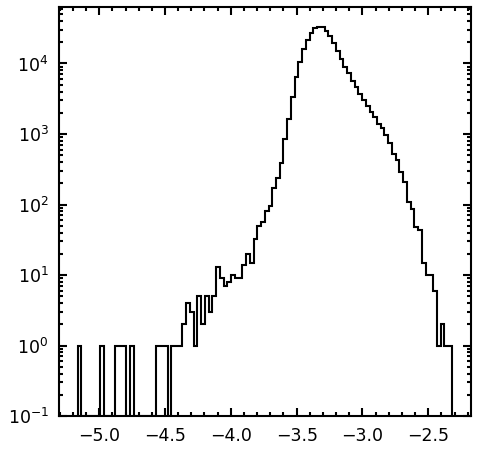

In [26]:
plt.hist(np.log10(min_deem_iza_distances[n_iza:, 0]), bins=100, log=True, histtype='step')

plt.show()

In [27]:
de_limit = 10.0
df_limit = 0.0

gch_vertices_de = np.nonzero(de < de_limit)[0]
iza_vertices_de = gch_vertices_de[gch_vertices_de < n_iza]
deem_vertices_de = gch_vertices_de[gch_vertices_de >= n_iza]

gch_vertices_df = np.nonzero(dfs < df_limit)[0]
iza_vertices_df = gch_vertices_df[gch_vertices_df < n_iza]
deem_vertices_df = gch_vertices_df[gch_vertices_df >= n_iza]

gch_vertices_df_de = np.intersect1d(gch_vertices_de, gch_vertices_df)
iza_vertices_df_de = gch_vertices_df_de[gch_vertices_df_de < n_iza]
deem_vertices_df_de = gch_vertices_df_de[gch_vertices_df_de >= n_iza]

In [28]:
# Print some extra info for the above Deem frameworks
# in a format we can copy and paste into a LaTeX table
class_key = {1: 'IZA1', 2:'IZA2', 3:'IZA3', 4:'Deem'}
select_deem_codes = deem_codes[deem_vertices_df_de - n_iza]
select_deem_de = de[deem_vertices_df_de]
select_deem_dfs_2 = dfs_2[deem_vertices_df_de]
select_deem_cantons_4 = predicted_deem_cantons_4[deem_vertices_df_de - n_iza]

# Top 50 candidates close to hull
n_top = 50
hull_sort_idxs = np.argsort(select_deem_de)[0:n_top]

# Sort
df_sort_idxs = np.argsort(select_deem_dfs_2[hull_sort_idxs])

for idx, (deem_code, hull_distance, dec_func, canton, iza_code, iza_canton, iza_dist) in enumerate(zip(
    select_deem_codes[hull_sort_idxs][df_sort_idxs],
    select_deem_de[hull_sort_idxs][df_sort_idxs],
    select_deem_dfs_2[hull_sort_idxs][df_sort_idxs],
    [class_key[canton] for canton in select_deem_cantons_4[hull_sort_idxs][df_sort_idxs]],
    iza_codes[min_deem_iza_distance_idxs[:, 0]][hull_sort_idxs][df_sort_idxs],
    iza_cantons[min_deem_iza_distance_idxs[:, 0]][hull_sort_idxs][df_sort_idxs],
    min_deem_iza_distances[hull_sort_idxs, 0][df_sort_idxs]
)):
    
    print(
        f'({idx+1:2d}) & '
        f'{deem_code} & '
        f'\\num{{{hull_distance:0.2e}}} & '
        f'{dec_func:0.2f} & '
        f'{canton} & '
        f'{iza_code} (IZA{iza_canton}) & '
        f'\\num{{{iza_dist:0.2e}}} \\\\'
    )

( 1) & 8283748 & \num{-0.00e+00} & -4.57 & IZA2 & VNI (IZA2) & \num{3.96e-04} \\
( 2) & 8162069 & \num{-1.71e-12} & -3.90 & IZA3 & BRE (IZA2) & \num{7.86e-04} \\
( 3) & 8054476 & \num{-2.71e-12} & -3.55 & IZA2 & MTF (IZA1) & \num{6.47e-04} \\
( 4) & 8214845 & \num{9.81e-02} & -3.20 & IZA2 & UEI (IZA3) & \num{5.41e-04} \\
( 5) & 8264888 & \num{4.67e-01} & -2.96 & IZA2 & AWO (IZA3) & \num{5.15e-04} \\
( 6) & 8330882 & \num{-0.00e+00} & -2.94 & IZA1 & VET (IZA1) & \num{4.96e-04} \\
( 7) & 8330992 & \num{6.90e-02} & -2.85 & IZA2 & JNT (IZA3) & \num{8.85e-04} \\
( 8) & 8315376 & \num{5.52e-01} & -2.53 & IZA3 & IFR (IZA1) & \num{5.56e-04} \\
( 9) & 8158735 & \num{-2.02e-12} & -2.14 & IZA2 & PTY (IZA2) & \num{3.66e-04} \\
(10) & 8321619 & \num{5.74e-01} & -1.74 & IZA3 & DFO (IZA3) & \num{4.83e-04} \\
(11) & 8252698 & \num{5.19e-01} & -1.70 & IZA3 & ATS (IZA3) & \num{6.22e-04} \\
(12) & 8245432 & \num{5.14e-01} & -1.65 & IZA2 & MSO (IZA2) & \num{6.95e-04} \\
(13) & 8248935 & \num{5.53e-01} & -

In [29]:
# Expanded table: 3 nearest IZA, cantons, and distances
# stratified by molar volume. Take top 5 for each stratification
class_key = {1: 'IZA1', 2:'IZA2', 3:'IZA3', 4:'Deem'}

# List of (min, max) molar volumes
strata = [(50, 55), (55, 60), (60, 65), (65, 70)]

# Top 5 candidates close to hull
n_top = 5

for stratum in strata:
    vol_idxs = np.nonzero(np.logical_and(volumes > stratum[0], volumes <= stratum[1]))[0]
    select_idxs = vol_idxs[np.argsort(de[vol_idxs])]
    select_deem_idxs = select_idxs[select_idxs >= n_iza][0:n_top]
#     select_deem_idxs = select_deem_idxs[np.argsort(dfs[select_deem_idxs])]
    
    table_str = f'\\multirow{{19}}{{*}}{{{stratum[0]}--{stratum[1]} \\AA{{}}$^3$}}'
    for idx, i in enumerate(select_deem_idxs):        
        nearest_iza_idxs = min_deem_iza_distance_idxs[i-n_iza]
    
        table_str += (
            f' & \\multirow{{{n_iza_neighbors}}}{{*}}{{({idx+1:1d})}}'
            f' & \\multirow{{{n_iza_neighbors}}}{{*}}{{{codes[i]}}}'
            f' & \\multirow{{{n_iza_neighbors}}}{{*}}{{{volumes[i]:0.2f}}}'
            f' & \\multirow{{{n_iza_neighbors}}}{{*}}{{{predicted_Si_fraction[i]:0.2f}}}'
            f' & \\multirow{{{n_iza_neighbors}}}{{*}}{{\\num{{{de[i]:0.2e}}}}}'
            f' & \\multirow{{{n_iza_neighbors}}}{{*}}{{{dfs[i]:0.2f}}}'
            f' & \\multirow{{{n_iza_neighbors}}}{{*}}{{{class_key[predicted_cantons_4[i]]}}}'
        )
        
        for jdx, j in enumerate(nearest_iza_idxs[0:n_iza_neighbors]):
            sub_table_str = (
                f' & {codes[j]}'
                f' & {Si_fraction[j]:0.2f}'
                f' & IZA{cantons_4[j]}'
                f' & \\num{{{min_deem_iza_distances[i, jdx]:0.2e}}} \\\\\n'
            )
            
            if jdx > 0:
                sub_table_str = ' &' * 7 + sub_table_str
        
            table_str += sub_table_str
        if idx <  n_top-1:   
            table_str += ' &' * 11 + ' \\\\\n'
    table_str += '\\hline\n'
    print(table_str)

\multirow{19}{*}{50--55 \AA{}$^3$} & \multirow{3}{*}{(1)} & \multirow{3}{*}{8330882} & \multirow{3}{*}{53.09} & \multirow{3}{*}{0.28} & \multirow{3}{*}{\num{-0.00e+00}} & \multirow{3}{*}{-2.94} & \multirow{3}{*}{IZA1} & MEP & 0.33 & IZA1 & \num{4.58e-04} \\
 & & & & & & & & DDR & 0.33 & IZA1 & \num{5.48e-04} \\
 & & & & & & & & DOH & 0.33 & IZA1 & \num{6.01e-04} \\
 & & & & & & & & & & & \\
 & \multirow{3}{*}{(2)} & \multirow{3}{*}{8330992} & \multirow{3}{*}{51.61} & \multirow{3}{*}{0.29} & \multirow{3}{*}{\num{6.90e-02}} & \multirow{3}{*}{-2.85} & \multirow{3}{*}{IZA2} & MWW & 0.31 & IZA2 & \num{5.96e-04} \\
 & & & & & & & & DAC & 0.26 & IZA2 & \num{6.46e-04} \\
 & & & & & & & & STF & 0.33 & IZA1 & \num{6.56e-04} \\
 & & & & & & & & & & & \\
 & \multirow{3}{*}{(3)} & \multirow{3}{*}{8156062} & \multirow{3}{*}{52.95} & \multirow{3}{*}{0.11} & \multirow{3}{*}{\num{1.82e-01}} & \multirow{3}{*}{-1.08} & \multirow{3}{*}{IZA3} & ATN & 0.00 & IZA3 & \num{4.60e-04} \\
 & & & & & & & & LTN & 0

In [30]:
de_max = 10.0
df_max = 0.0

zoom_idxs = np.intersect1d(
    np.nonzero(de <= de_max)[0],
    np.nonzero(dfs <= df_max)[0]
)

vol_vmin = np.amin(volumes[zoom_idxs])
vol_vmax = np.amax(volumes[zoom_idxs])

vol_sizes = scale_points(volumes, size_min, size_max, inverted=False, log=False, base=base, min_limit=vol_vmin, max_limit=vol_vmax)
vol_alphas = scale_points(volumes, alpha_min, alpha_max, inverted=False, log=False, base=base, min_limit=vol_vmin, max_limit=vol_vmax)

vol_norm = Normalize(vmin=vol_vmin, vmax=vol_vmax)
vol_color_map = ScalarMappable(norm=vol_norm, cmap='plasma')
vol_colors = vol_color_map.to_rgba(volumes, alpha=1.0)
vol_colors[:, -1] = vol_alphas

vol_ecolors = np.tile(to_rgba(color_list[0]), (len(vol_colors), 1))
vol_ecolors[:, -1] = vol_alphas

vol_po_iza = np.argsort(volumes[0:n_iza])
vol_po_deem = np.argsort(volumes[n_iza:])

In [31]:
from sklearn.neighbors import KernelDensity
def silvermans_rule(n, d):
    h = (n * (d + 2) / 4) ** (-1 / (d + 4))
    return h

In [32]:
# Load Deem 10k PCA
deem_pca = utils.load_hdf5(f'{deem_dir}/{cutoff}/LPCA/pca_structures.hdf5')[deem_idxs]

# Load IZA PCA
iza_pca = utils.load_hdf5(f'{iza_dir}/{cutoff}/LPCA/pca_structures.hdf5')[iza_idxs]

pca = np.vstack((iza_pca, deem_pca))

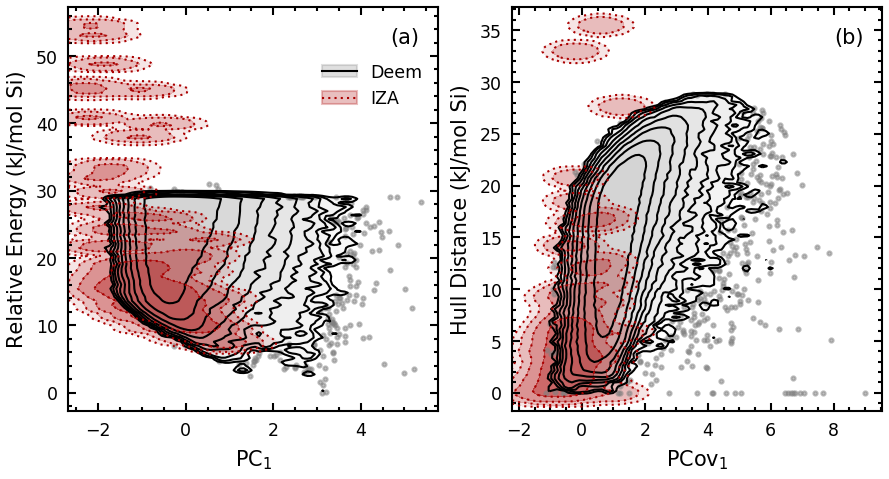

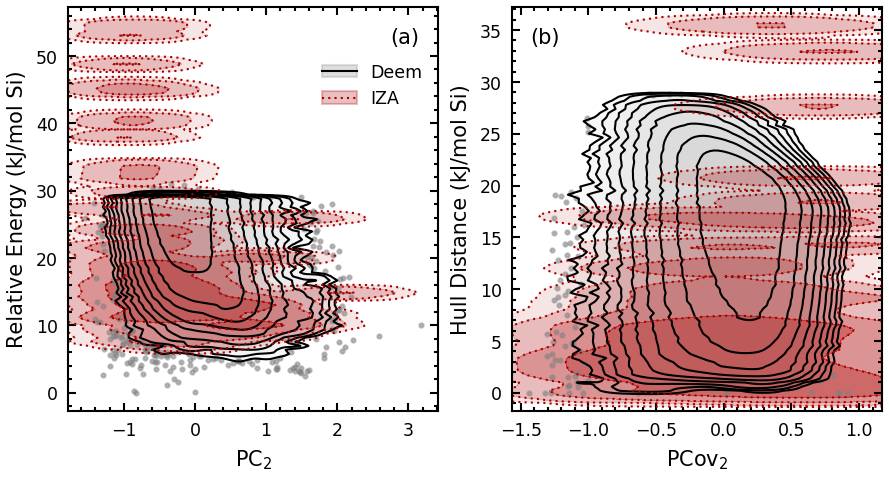

In [33]:
margin = 0.05
for pdx in range(0, 2):
    fig = plt.figure(figsize=(7.0, 3.5))
    axes = [fig.add_subplot(1, 2, i+1) for i in range(0, 2)]
    
#     grouper = axes[0].get_shared_y_axes()
#     for ax in axes[1:]:
#         grouper.join(ax, axes[0])
        
    for axs, pc, en, pc_label, en_label, plot_label in zip(
        axes, [pca, T], 
        [energies - np.amin(energies), de], 
        ['PC', 'PCov'], 
        ['Relative Energy', 'Hull Distance'],
        ['(a)', '(b)']
    ):

        xlen = np.amax(pc[:, pdx]) - np.amin(pc[:, pdx])
        xlim = (np.amin(pc[:, pdx]) - margin * xlen, np.amax(pc[:, pdx]) + margin * xlen)

        ylen = np.amax(en) - np.amin(en)
        ylim = (np.amin(en) - margin * ylen, np.amax(en) + margin * ylen)

        axs.set_xlim(xlim)
        axs.set_ylim(ylim)

        x_grid = np.linspace(xlim[0], xlim[1], 100)
        y_grid = np.linspace(ylim[0], ylim[1], 100)

        X_grid, Y_grid = np.meshgrid(x_grid, y_grid)
        grid_samples = np.dstack((X_grid, Y_grid)).reshape(X_grid.size, 2)

        h_deem = silvermans_rule(len(en) - n_iza, 2)
        h_iza = silvermans_rule(n_iza, 2)

        t_deem = np.column_stack((pc[n_iza:, pdx], en[n_iza:]))
        deem_kde = KernelDensity(bandwidth=h_deem)
        deem_kde.fit(t_deem)
        
        t_iza = np.column_stack((pc[0:n_iza, pdx], en[0:n_iza]))
        iza_kde = KernelDensity(bandwidth=h_iza)
        iza_kde.fit(t_iza)

        Z_grid_iza = np.exp(iza_kde.score_samples(grid_samples).reshape(X_grid.shape))
        Z_grid_deem = np.exp(deem_kde.score_samples(grid_samples).reshape(X_grid.shape))

        Z_max_iza = np.log10(np.amax(Z_grid_iza))
        Z_max_deem = np.log10(np.amax(Z_grid_deem))
        
        min_level_deem = Z_max_deem - 3
        min_level_iza = Z_max_iza - 3

#         min_level = np.maximum(min_level_iza, min_level_deem)
#         max_level = np.minimum(Z_max_iza, Z_max_deem)

        n_levels_deem = 10
        levels_deem = np.logspace(min_level_deem, Z_max_deem, n_levels_deem)
#         levels_deem = np.logspace(min_level, max_level, n_levels_deem)
        alpha_levels_deem = np.linspace(0.1, 0.75, n_levels_deem)

        n_levels_iza = 5
        levels_iza = np.logspace(min_level_iza, Z_max_iza, n_levels_iza)
#         levels_iza = np.logspace(min_level, max_level, n_levels_iza)
        alpha_levels_iza = np.linspace(0.1, 0.75, n_levels_iza)

        axs.contour(
            X_grid,
            Y_grid,
            Z_grid_deem,
            colors=color_list[0],
            linestyles='-',
            levels=levels_deem,
        )

        axs.contour(
            X_grid,
            Y_grid,
            Z_grid_iza,
            colors=color_list[1],
            linestyles=':',
            levels=levels_iza,
        )

        level_colors_deem = np.tile(to_rgba(color_list[11]), (n_levels_deem, 1))
        level_colors_deem[:, -1] = alpha_levels_deem
        axs.contourf(
            X_grid,
            Y_grid,
            Z_grid_deem,
            colors=level_colors_deem,
            levels=levels_deem
        )

        level_colors_iza = np.tile(to_rgba(color_list[1]), (n_levels_iza, 1))
        level_colors_iza[:, -1] = alpha_levels_iza
        axs.contourf(
            X_grid,
            Y_grid,
            Z_grid_iza,
            colors=level_colors_iza,
            levels=levels_iza
        )

        # Plot IZA outside contours
        iza_scatter_idxs = np.argmin(pairwise_distances(t_iza, grid_samples), axis=1)
        iza_scatter_idxs = np.nonzero(Z_grid_iza.flatten()[iza_scatter_idxs] < 10**(min_level_iza))[0]
        
        axs.scatter(
            pc[iza_scatter_idxs, pdx],
            en[iza_scatter_idxs],
            marker='s',
            color=color_list[1]
        )
        
        # Plot Deem outside contours
        deem_scatter_idxs = []
        batch_size = 10000
        n_batches = n_deem // batch_size
        if n_deem % batch_size > 0:
            n_batches += 1
        for n in range(0, n_batches):
            t_deem_batch = t_deem[n*batch_size:(n+1)*batch_size]
            deem_scatter_idxs.extend(np.argmin(pairwise_distances(t_deem_batch, grid_samples), axis=1))
        
        deem_scatter_idxs = np.nonzero(Z_grid_deem.flatten()[deem_scatter_idxs] < 10**(min_level_deem))[0]
        
        axs.scatter(
            pc[deem_scatter_idxs+n_iza, pdx],
            en[deem_scatter_idxs+n_iza],
            marker='o',
            color=color_list[5],
            alpha=0.5
        )

        axs.set_xlabel(fr'{pc_label}$_{{{pdx+1}}}$')
        axs.set_ylabel(f'{en_label} (kJ/mol Si)')
        
        if pdx == 1 and plot_label == '(b)':
            label_pos = [0.05, 0.95]
            ha = 'left'
        else:
            label_pos = [0.95, 0.95]
            ha = 'right'
        axs.text(
            *label_pos, plot_label, 
            horizontalalignment=ha, 
            verticalalignment='top', 
            transform=axs.transAxes
        )
    
    handles = [
        (
            Patch(color=color_list[5], alpha=0.25),            
            Line2D([0], [0], linestyle='-', color=color_list[0])
        ),
        (
            Patch(color=color_list[1], alpha=0.25),
            Line2D([0], [0], linestyle=':', color=color_list[1])
        )
    ]
    labels = ['Deem', 'IZA']
    axes[0].legend(handles=handles, labels=labels, loc='upper right', bbox_to_anchor=(1.0, 0.9))

    fig.subplots_adjust(wspace=0.2)
    
    fig.savefig(f'../../Results/{cutoff}/energy_contours_{cutoff}_pc_pcov_{pdx+1}.pdf', bbox_inches='tight')

    plt.show()

# Build a chemiscope

In [34]:
np.count_nonzero(np.logical_and(de < 5, dfs < 0))

4733

In [35]:
np.count_nonzero(np.nonzero(de < 5)[0] < n_iza)

161

In [36]:
161/229

0.7030567685589519

In [37]:
np.count_nonzero(np.nonzero(de < 10)[0] < n_iza)

212

In [38]:
212/229

0.925764192139738

In [39]:
# Construct a chemiscope on a broad subset of the most promising structures
chemiscope_de_limit = 5.0
chemiscope_df_limit = 0.0
chemiscope_deem_idxs = np.intersect1d(
    np.nonzero(de < chemiscope_de_limit)[0],
    np.nonzero(dfs < chemiscope_df_limit)[0]
)
chemiscope_deem_idxs = chemiscope_deem_idxs[chemiscope_deem_idxs >= n_iza]
chemiscope_deem_frames = [deepcopy(frames[i]) for i in chemiscope_deem_idxs]

chemiscope_iza_frames = deepcopy(frames[0:n_iza])
chemiscope_iza_idxs = np.arange(0, n_iza)

chemiscope_frames = chemiscope_iza_frames + chemiscope_deem_frames
chemiscope_idxs = np.concatenate((chemiscope_iza_idxs, chemiscope_deem_idxs))

chemiscope_min_deem_iza_distances = min_deem_iza_distances[chemiscope_idxs]
scaled_chemiscope_min_deem_iza_distances = (
    (chemiscope_min_deem_iza_distances - np.amin(chemiscope_min_deem_iza_distances))
    / (np.amax(chemiscope_min_deem_iza_distances) - np.amin(chemiscope_min_deem_iza_distances))
)

# Strip the properties from the frames, we will set them manually
for frame in chemiscope_frames:
    frame.info = {}

In [40]:
def int_class_to_str(class_ints, n_classes=2):
    conversion_dict = {
        2: {1: 'IZA', 2:'Deem'},
        4: {1: 'IZA1', 2:'IZA2', 3:'IZA3', 4:'Deem'}
    }
    return np.array([conversion_dict[n_classes][c] for c in class_ints])

In [41]:
# Also 2 and 4 class decision function values
chemiscope_properties = dict(
    codes=dict(target='structure', values=codes[chemiscope_idxs]),
    projection=dict(target='structure', values=T[chemiscope_idxs, 0:2]),
    energies=dict(target='structure', values=energies[chemiscope_idxs]),
    volumes=dict(target='structure', values=volumes[chemiscope_idxs]),
    vertex=dict(target='structure', values=vertex_indicators[chemiscope_idxs]),
#     vertex_probability=dict(target='structure', values=vprobprune[prune_iter][chemiscope_idxs]),
    true_class_2=dict(target='structure', values=int_class_to_str(cantons_2[chemiscope_idxs])),
    true_class_4=dict(target='structure', values=int_class_to_str(cantons_4[chemiscope_idxs], n_classes=4)),
    predicted_class_2=dict(target='structure', values=int_class_to_str(predicted_cantons_2[chemiscope_idxs])),
    predicted_class_4=dict(target='structure', values=int_class_to_str(predicted_cantons_4[chemiscope_idxs], n_classes=4)),
    decision_function_2=dict(target='structure', values=dfs_2[chemiscope_idxs]),
    decision_function_4=dict(target='structure', values=dfs_4[chemiscope_idxs]),
    hull_distance=dict(target='structure', values=d[chemiscope_idxs]),
    hull_distance_energy=dict(target='structure', values=de[chemiscope_idxs]),
    Si_fraction=dict(target='structure', values=Si_fraction[chemiscope_idxs]),
    deem_iza_distance=dict(target='structure', values=chemiscope_min_deem_iza_distances),
    scaled_deem_iza_distance=dict(target='structure', values=scaled_chemiscope_min_deem_iza_distances)
)

In [42]:
chemiscope.write_input(
    f'{ch_dir}/svm-pcovr-ch_chemiscope{mixing}.json.gz', 
    chemiscope_frames, 
    meta=dict(name='SVM-PCovR-CH'),
    properties=chemiscope_properties,
    cutoff=None
)

## Plot the "chemiscope"

In [43]:
with gzip.GzipFile(f'{ch_dir}/svm-pcovr-ch_chemiscope{mixing}.json.gz', 'r') as f:
    data = json.load(f)

In [44]:
T1 = np.array(data['properties']['projection[1]']['values'])
T2 = np.array(data['properties']['projection[2]']['values'])
E = np.array(data['properties']['energies']['values'])
hull_distance = np.array(data['properties']['hull_distance']['values'])
hull_distance_energy = np.array(data['properties']['hull_distance_energy']['values'])
true_class = np.array(data['properties']['true_class_2']['values'])
predicted_class = np.array(data['properties']['predicted_class_2']['values'])
vertex = np.array(data['properties']['vertex']['values'])
# vertex_probability = np.array(data['properties']['vertex_probability']['values'])

In [45]:
symbols = []
for t in true_class:
    if t == 'DEEM':
        symbols.append('circle')
    elif t == 'IZA1':
        symbols.append('square')
    elif t == 'IZA2':
        symbols.append('diamond')
    elif t == 'IZA3':
        symbols.append('cross')

In [46]:
classes = sorted(list(set(true_class)))

In [47]:
fig = go.Figure()

for t, s in zip(classes, ('circle', 'square', 'diamond', 'cross')):
    v = vertex[true_class == t]
    X = T1[true_class == t]
    Y = T2[true_class == t]
    Z = E[true_class == t]
    HDE = hull_distance_energy[true_class == t]
    fig.add_trace(go.Scatter3d(
        x=X, 
        y=Y, 
        z=Z, 
        mode='markers',
        marker=dict(
            color=HDE,
            coloraxis='coloraxis',
            line_width=1,
            size=3,
            symbol=s,
        ),
        name=t,
        hovertemplate="%{marker.color}"
    ))
    fig.add_trace(go.Scatter3d(
        x=X[np.nonzero(v)[0]], 
        y=Y[np.nonzero(v)[0]], 
        z=Z[np.nonzero(v)[0]], 
        mode='markers',
        marker=dict(
            color=HDE[np.nonzero(v)[0]],
            coloraxis='coloraxis',
            line_width=1,
            size=8,
            symbol=s,
        ),
        name=t,
        hovertemplate="%{marker.color}"
    ))

fig.add_trace(go.Mesh3d(
    alphahull=-1,
    x=T1[np.nonzero(vertex)[0]], 
    y=T2[np.nonzero(vertex)[0]], 
    z=E[np.nonzero(vertex)[0]],
    color='skyblue',
    opacity=0.25,
    hoverinfo='skip'    
))

fig.update_layout(
    template='plotly_white',
    scene=dict(
        xaxis_title='T<sub>1</sub>',
        yaxis_title='T<sub>2</sub>',
        zaxis_title='Energy per Si<br>(kJ/mol Si)'
    ),
    legend=dict(
        x=0.0, 
        y=1.0,
        xanchor='left', 
        yanchor='top',
        itemsizing='constant'
    ),
    coloraxis=dict(
        colorscale='RdBu',
        colorbar=dict(title='Hull Distance<br>(kJ/mol)'),
        cmid=0
    ),
    autosize=False,
    width=600, 
    height=600
)

fig.show()
#fig.write_image('../../Results/6.0/SVM-KPCovR-CH.png')

In [48]:
fig = go.Figure()

X = np.array(data['properties']['hull_distance_energy']['values'])
Y = np.array(data['properties']['decision_function_2']['values'])
Z = np.array(data['properties']['volumes']['values'])
C = np.array(data['properties']['codes']['values'])
DID = np.array(data['properties']['deem_iza_distance[1]']['values'])

for t, s in zip(classes, ('circle', 'square', 'diamond', 'cross')):
#     if t == 'IZA':
#         continue
    
    x=X[true_class == t] 
    y=Y[true_class == t] 
    z=Z[true_class == t] 
    fig.add_trace(go.Scatter3d(
        x=x, 
        y=y, 
        z=z, 
        mode='markers',
        marker=dict(
            color=DID,
            coloraxis='coloraxis',
            line_width=1,
            size=3,
            symbol=s,
        ),
        customdata=C[true_class == t],
        hovertemplate='%{customdata}',
        name=t
    ))
    
# fig.add_trace(go.Mesh3d(
#     alphahull=0,
#     x=x, 
#     y=y, 
#     z=z,
#     color='skyblue',
#     opacity=0.25,
#     hoverinfo='none'    
# ))

fig.update_layout(
    template='plotly_white',
    scene=dict(
        xaxis_title='E',
        yaxis_title='DF',
        zaxis_title='V'
    ),
    legend=dict(
        x=0.0, 
        y=1.0,
        xanchor='left', 
        yanchor='top',
        itemsizing='constant'
    ),
    coloraxis=dict(
        colorscale='Plasma',
        colorbar=dict(title='Deem-IZA Distance'),
    )
)

fig.show()
#fig.write_image('../../Results/6.0/SVM-KPCovR-GCH.png')